In [1]:
import warnings
from pathlib import Path
import matplotlib as mpl
import iris
import iris.pandas
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from aeolus.calc.diag import toa_eff_temp
from aeolus.calc.stats import spatial_mean
from aeolus.coord import get_cube_rel_days, interp_to_cube_time
from aeolus.model import um
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.plot import subplot_label_generator
from aeolus.plot import add_custom_legend, subplot_label_generator
metallicity = "solar"
from aeolus.coord import coord_to_cube, regrid_3d, replace_z_coord, volume_weights_cube
from aeolus.model import um
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels

In [2]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")

In [3]:
parents_dir = Path.home().parent.parent/"data" / "mz355" /"um_runs"/"wasp96b"/"kinetics"/"u-cp238"/"raw"
flist = []
for windfile in parents_dir.glob('**/atmos_base_*/atmosa.*'):  # this directory and all subdirectories, recursively
     if ("atmosa.pc" in windfile.name or "atmosa.pb" in windfile.name):
        flist.append(str(windfile))

len(sorted(flist))

print(sorted(flist))

['/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0010/atmosa.pb00000000_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0010/atmosa.pc00000000_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0020/atmosa.pb00000010_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0020/atmosa.pc00000010_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0030/atmosa.pb00000020_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0030/atmosa.pc00000020_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0040/atmosa.pb00000030_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0040/atmosa.pc00000030_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0050/atmosa.pb00000040_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0050/atmosa.pc00000040_00', '/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_0060/atmosa.pb00000050_00', '/data/mz355/um_runs

In [4]:
winds = iris.load(flist)

In [5]:
#winds

In [6]:
u = winds.extract_cube(um.u)
pres = winds.extract_cube(um.pres)
print(u.shape, pres.shape)

pres_66 = pres[:,0:66]
pres_66.shape



(100, 66, 90, 144) (100, 67, 90, 144)


(100, 66, 90, 144)

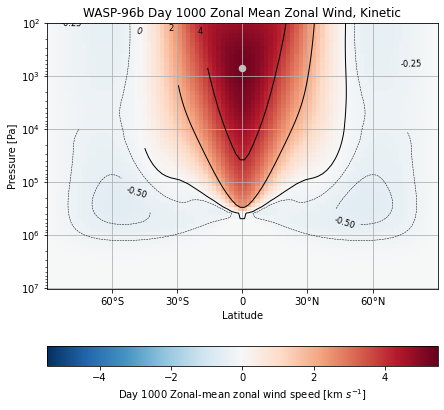

In [13]:

#just change the range to whatever time values you want 

for n in range(99,100):
    u_loop = u[n,:,:,:]
    pres_66_loop = pres_66[n,:,:,:]
    lats_coord = u_loop.coord("latitude")
    #interpolate u wind speed to pressure levels
    u_plevs = interp_cube_from_height_to_pressure_levels(u_loop, pres_66_loop, tgt_plevs)
    pres_coord = u_plevs.coord("air_pressure")
    #calculate zonal mean zonal wind speed
    u_plevs_znl_mean = u_plevs.collapsed(["time", "longitude"], iris.analysis.MEAN)
    u_plevs_znl_mean.convert_units("km s-1")
    #find max zonal-mean zonal wind speed direction
    max_u_z, max_u_y = np.where(u_plevs_znl_mean.data == u_plevs_znl_mean.data.max())
    #print(u_plevs_znl_mean.data.max())
    #print(u_plevs_znl_mean.data.min())


    fig,ax = plt.subplots(figsize=(7,7))
    ax.invert_yaxis()
    iletters = subplot_label_generator()


    p0 = ax.pcolormesh(
            lats_coord.points,
            pres_coord.points,
            u_plevs_znl_mean.data,
            norm = mpl.colors.Normalize(vmin=-5.47, vmax=5.47),
            cmap="RdBu_r",
            shading="auto",
            rasterized=True,
        )

    p1 = ax.contour(
                lats_coord.points,
                pres_coord.points,
                u_plevs_znl_mean.data,
                levels=np.arange(-2, 8, 2),
                colors="k",
                linewidths=1,
            )

    p2 = ax.contour(
            lats_coord.points,
            pres_coord.points,
            u_plevs_znl_mean.data,
            levels=[l for l in np.arange(-2, 0.25, 0.25) if l != 0.0],
            colors="k",
            linewidths=0.5,
        )

    ax.clabel(p1, p1.levels, inline=True, fmt="%.0f", fontsize="small")
    ax.clabel(p2, p2.levels, inline=True, fmt="%.2f", fontsize="small")
    # Add grid
    ax.grid()
    # Add max zonal-mean zonal wind speed location
    ax.plot(
        abs(lats_coord.points[max_u_y]) - 1,
        pres_coord.points[max_u_z],
        marker=".",
        color="silver",
        markersize=10,
        markeredgewidth=2.5,
        )
    
    if n == 0:
        days = 10
    else: 
        days = (n*10)+10
            

    ax.set_yscale("log")
    ax.set_xticks([-60, -30, 0, 30, 60])
    ax.set_xticklabels(["60°S", "30°S", "0", "30°N", "60°N"])
    ax.set_title("WASP-96b Day {} Zonal Mean Zonal Wind, Kinetic".format(days), loc="center")
    ax.set_ylabel("Pressure [Pa]")
    ax.set_xlabel("Latitude")
    fig.colorbar(
    p0,
    ax=ax,
    label="Day {} Zonal-mean zonal wind speed [km $s^{}$]".format(days,{-1}),
    orientation="horizontal",
    #shrink=0.3,
    )
    plt.savefig("zonal_wind_kinetic_1000")




In [ ]:
print(u_plevs_znl_mean.data.max())
print(u_plevs_znl_mean.data.min())

5.204622414216865
-0.4913728252934056
